In [ ]:
import os
os.listdir()

: 

In [2]:
%%capture
%pip install -U ipykernel

In [3]:
%%capture
%pip install pyro-ppl==0.3.0 kornia mayavi pyqt5 ipywidgets ipyevents

Code from [here](https://stackoverflow.com/questions/13932150/matplotlib-wrong-overlapping-when-plotting-two-3d-surfaces-on-the-same-axes)

In [ ]:
import warnings
import logging
from dataclasses import dataclass
from numbers import Number
from typing import Any
from typing import Dict
from typing import final
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import Union

import torch
from torch.distributions import Distribution
from torch.distributions import Laplace
from torch.distributions import Normal

from disent.frameworks.ae._unsupervised__ae import Ae
from disent.frameworks.vae import BetaVae

from disent.frameworks.helper.latent_distributions import LatentDistsHandler
from disent.frameworks.helper.latent_distributions import make_latent_distribution
from disent.frameworks.helper.util import detach_all

from disent.util import map_all

from dataclasses import fields
from typing import Sequence
from typing import Tuple, final

import numpy as np


from disent.frameworks.helper.reductions import loss_reduction
from disent.frameworks.helper.util import compute_ave_loss
from disent.frameworks.helper.latent_distributions import LatentDistsHandler


from disent.model.ae.base import AutoEncoder
REQUIRED_Z_MULTIPLIER = 2
REQUIRED_OBS = 1


#_model: AutoEncoder = make_model_fn() 
# --------------------------------------------------------------------- #
# VAE Training Step                                                     #
# --------------------------------------------------------------------- #

def _get_xs_and_targs(batch: Dict[str, Tuple[torch.Tensor, ...]]) -> Tuple[Tuple[torch.Tensor, ...], Tuple[torch.Tensor, ...]]:
    xs_targ = batch['x_targ']
    if 'x' not in batch:
        warnings.warn('dataset does not have input: x -> x_targ using target as input: x_targ -> x_targ')
        xs = xs_targ
    else:
        xs = batch['x']
    # check that we have the correct number of inputs
    if (len(xs) != REQUIRED_OBS) or (len(xs_targ) != REQUIRED_OBS):
        log.warning(f'batch len(xs)={len(xs)} and len(xs_targ)={len(xs_targ)} observation count mismatch, requires: {REQUIRED_OBS}')
    # done
    return xs, xs_targ

def do_training_step(batch, batch_idx):
    xs, xs_targ = _get_xs_and_targs(batch, batch_idx)

    # FORWARD
    # -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- #
    # latent distribution parameterizations
    ds_posterior, ds_prior = map_all(encode_dists, xs, collect_returned=True)

    """
    # [HOOK] disable learnt scale values
    ds_posterior, ds_prior = _hook_intercept_ds_disable_scale(ds_posterior, ds_prior)
    # [HOOK] intercept latent parameterizations
    ds_posterior, ds_prior, logs_intercept_ds = hook_intercept_ds(ds_posterior, ds_prior)
    """
    # sample from dists
    zs_sampled = tuple(d.rsample() for d in ds_posterior)
    # reconstruct without the final activation
    xs_partial_recon = map_all(decode_partial, detach_all(zs_sampled, if_=cfg.disable_decoder))
    # -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- #

    # LOSS
    # -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- #
    # compute all the recon losses
    recon_loss, logs_recon = compute_ave_recon_loss(xs_partial_recon, xs_targ)
    # compute all the regularization losses
    reg_loss, logs_reg = compute_ave_reg_loss(ds_posterior, ds_prior, zs_sampled)
    # [HOOK] augment loss
    aug_loss, logs_aug = hook_compute_ave_aug_loss(ds_posterior=ds_posterior, ds_prior=ds_prior, zs_sampled=zs_sampled, xs_partial_recon=xs_partial_recon, xs_targ=xs_targ)
    # compute combined loss
    loss = 0
    if not cfg.disable_rec_loss: loss += recon_loss
    if not cfg.disable_aug_loss: loss += aug_loss
    if not cfg.disable_reg_loss: loss += reg_loss
    # -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~- #

    # return values
    return loss, {
        **logs_intercept_ds,
        **logs_recon,
        **logs_reg,
        **logs_aug,
        'recon_loss': recon_loss,
        'reg_loss': reg_loss,
        'aug_loss': aug_loss,
    }

# --------------------------------------------------------------------- #
# Delete AE Hooks                                                       #
# --------------------------------------------------------------------- #


def hook_ae_intercept_zs(zs: Sequence[torch.Tensor]) -> Tuple[Sequence[torch.Tensor], Dict[str, Any]]:
    raise NotImplementedError('This function should never be used or overridden by VAE methods!')  # pragma: no cover


def hook_ae_compute_ave_aug_loss(zs: Sequence[torch.Tensor], xs_partial_recon: Sequence[torch.Tensor], xs_targ: Sequence[torch.Tensor]) -> Tuple[Union[torch.Tensor, Number], Dict[str, Any]]:
    raise NotImplementedError('This function should never be used or overridden by VAE methods!')  # pragma: no cover

# --------------------------------------------------------------------- #
# Private Hooks                                                         #
# --------------------------------------------------------------------- #

def _hook_intercept_ds_disable_scale(ds_posterior: Sequence[Distribution], ds_prior: Sequence[Distribution]):
    # disable posterior scales
    if cfg.disable_posterior_scale is not None:
        for d_posterior in ds_posterior:
            assert isinstance(d_posterior, (Normal, Laplace))
            d_posterior.scale = torch.full_like(d_posterior.scale, fill_value=cfg.disable_posterior_scale)
    # return modified values
    return ds_posterior, ds_prior

# --------------------------------------------------------------------- #
# Overrideable Hooks                                                    #
# --------------------------------------------------------------------- #

def hook_intercept_ds(ds_posterior: Sequence[Distribution], ds_prior: Sequence[Distribution]) -> Tuple[Sequence[Distribution], Sequence[Distribution], Dict[str, Any]]:
    return ds_posterior, ds_prior, {}

def hook_compute_ave_aug_loss(ds_posterior: Sequence[Distribution], ds_prior: Sequence[Distribution], zs_sampled: Sequence[torch.Tensor], xs_partial_recon: Sequence[torch.Tensor], xs_targ: Sequence[torch.Tensor]) -> Tuple[Union[torch.Tensor, Number], Dict[str, Any]]:
    return 0, {}

def compute_ave_reg_loss(ds_posterior: Sequence[Distribution], ds_prior: Sequence[Distribution], zs_sampled: Sequence[torch.Tensor]) -> Tuple[Union[torch.Tensor, Number], Dict[str, Any]]:
    # compute regularization loss (kl divergence)
    kl_loss = latents_handler.compute_ave_kl_loss(ds_posterior, ds_prior, zs_sampled)
    # return logs
    return kl_loss, {
        'kl_loss': kl_loss,
    }

# --------------------------------------------------------------------- #
# VAE - Encoding - Overrides AE                                         #
# --------------------------------------------------------------------- #

def encode(x: torch.Tensor) -> torch.Tensor:
    """Get the deterministic latent representation (useful for visualisation)"""
    z_raw = module.encode(x)
    z = latents_handler.encoding_to_representation(z_raw)
    return z

cfg=BetaVae.cfg(beta=0.003, loss_reduction='mean')
latents_handler = make_latent_distribution(cfg.latent_distribution, kl_mode=cfg.kl_loss_mode, reduction=cfg.loss_reduction)


def encode_dists(x: torch.Tensor) -> Tuple[Distribution, Distribution]:
    """Get parametrisations of the latent distributions, which are sampled from during training."""
    z_raw = module.encode(x)
    z_posterior, z_prior = latents_handler.encoding_to_dists(z_raw)
    return z_posterior, z_prior



: 

In [ ]:
from sklearn import linear_model
from disent.dataset.groundtruth import GroundTruthDatasetTriples
from disent.dataset.groundtruth import GroundTruthDistDataset
from disent.metrics._flatness import get_device
import pytorch_lightning as pl
from torch.optim import Adam
from torch.utils.data import DataLoader
from disent.data.groundtruth import XYObjectData, XYSquaresData
from disent.frameworks.vae import BetaVae
from disent.model.ae import EncoderConv64, DecoderConv64, AutoEncoder
from disent.transform import ToStandardisedTensor
from disent.util import colors
from disent.util import Timer

def get_str(r):
    return ', '.join(f'{k}={v:6.4f}' for k, v in r.items())

def print_r(name, steps, result, clr=colors.lYLW, t: Timer = None):
    print(f'{clr}{name:<13} ({steps:>04}){f" {colors.GRY}[{t.pretty}]{clr}" if t else ""}: {get_str(result)}{colors.RST}')

def calculate(name, steps, dataset, get_repr):
    print(get_repr)
    #global aggregate_measure_distances_along_factor
    #with Timer() as t:
    #    r = {
    #    #**metric_flatness_components(dataset, get_repr, factor_repeats=64, batch_size=64),
    #    #    **metric_flatness(dataset, get_repr, factor_repeats=64, batch_size=64),
    #    }
    #results.append((name, steps, r))
    #print_r(name, steps, r, colors.lRED, t=t)
    #print(colors.GRY, '='*100, colors.RST, sep='')
    #return r
    

class XYOverlapData(XYSquaresData):
    def __init__(self, square_size=8, grid_size=64, grid_spacing=None, num_squares=3, rgb=True):
        if grid_spacing is None:
            grid_spacing = (square_size+1) // 2
        super().__init__(square_size=square_size, grid_size=grid_size, grid_spacing=grid_spacing, num_squares=num_squares, rgb=rgb)

####################
#### train. ########
####################

results=[]
data= XYSquaresData()
dataset = GroundTruthDistDataset(data, transform=ToStandardisedTensor())
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, pin_memory=True)
cfg=BetaVae.cfg(beta=0.003, loss_reduction='mean')
module = BetaVae(
    make_optimizer_fn=lambda params: Adam(params, lr=5e-4),
    make_m1odel_fn=lambda: AutoEncoder(
        encoder=EncoderConv64(x_shape=data.x_shape, z_size=2, z_multiplier=2),
        decoder=DecoderConv64(x_shape=data.x_shape, z_size=2),
    ),
    cfg=cfg
)

latents_handler = make_latent_distribution(cfg.latent_distribution, kl_mode=cfg.kl_loss_mode, reduction=cfg.loss_reduction)

datum = next(iter(dataloader))
[x] = datum['x_targ']
z_posterior, z_prior = module.encode_dists(x)
z_posterior, z_prior



: 

In [ ]:
z_posterior.loc

: 

In [19]:
"""
posteriors = []
priors = []
for i, d in enumerate(dataloader):
    print(i)
    if i == 50: break
    [x] = d['x_targ']
    z_posterior, z_prior = module.encode_dists(x)
    posteriors.append(z_posterior), priors.append(z_prior)
"""


"\nposteriors = []\npriors = []\nfor i, d in enumerate(dataloader):\n    print(i)\n    if i == 50: break\n    [x] = d['x_targ']\n    z_posterior, z_prior = module.encode_dists(x)\n    posteriors.append(z_posterior), priors.append(z_prior)\n"

In [20]:
"""
import torch
import matplotlib.pyplot as plt

min = -4
max = 4


samples = []
n = 10
for i in range(0,n):
    samples.append(z_prior.sample())
  
bins = 1000
hist = torch.histc(torch.Tensor(samples), bins=bins, min=min, max=max, out=None)

# Printing the histogram of tensor
print("Latent hist")
#print("Latent hist", hist)
x = range(bins) #range(min,max)
plt.bar(x, hist, align='center', color=['forestgreen'])
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()
"""

'\nimport torch\nimport matplotlib.pyplot as plt\n\nmin = -4\nmax = 4\n\n\nsamples = []\nn = 10\nfor i in range(0,n):\n    samples.append(z_prior.sample())\n  \nbins = 1000\nhist = torch.histc(torch.Tensor(samples), bins=bins, min=min, max=max, out=None)\n\n# Printing the histogram of tensor\nprint("Latent hist")\n#print("Latent hist", hist)\nx = range(bins) #range(min,max)\nplt.bar(x, hist, align=\'center\', color=[\'forestgreen\'])\nplt.xlabel(\'Bins\')\nplt.ylabel(\'Frequency\')\nplt.show()\n'

In [19]:
z_posterior.loc.detach()

tensor([[-0.0523]])

In [51]:
z_prior.loc

tensor([[0., 0.]])

In [27]:
z_prior.loc.detach(), z_prior.scale.detach()




(tensor([[0., 0.]]), tensor([[1., 1.]]))

In [11]:
from mayavi import mlab
mlab.init_notebook(width=500, height=500, backend = "x3d")

Notebook initialized with x3d backend.


In [12]:
fig = mlab.figure()

ax_ranges = [-2, 2, -2, 2, 0, 8]
ax_scale = [1.0, 1.0, 0.4]
ax_extent = ax_ranges * np.repeat(ax_scale, 2)

#X, Y, Z_prior, Z_posterior = make_surfaces()

#surf1 = mlab.surf(X, Y, Z_prior, colormap='Blues')
#surf2 = mlab.surf(X, Y, Z_posterior, colormap='Oranges')

surf1 = mlab.surf(mx, my, mz1, colormap='Blues')


 μ mu_prior tensor([[0., 0.]]) 
 𝜎 sigma_prior tensor([[[1., 0.],
         [0., 1.]]]) 


 μ mu_posterior tensor([[-0.0170, -0.0338]]) 
 𝜎 sigma_posterior tensor([[[1.0012, 0.0000],
         [0.0000, 1.0034]]], grad_fn=<ViewBackward>) 



/var/folders/10/v6fg63596kb_zw6j2b74561r0000gn/T/ipykernel_51666/1628028854.py:45: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/10/v6fg63596kb_zw6j2b74561r0000gn/T/ipykernel_51666/1628028854.py:54: UserWarning: The following kwargs were not used by contour: 'zdifr'
  cset = ax.contourf(X, Y, Z_posterior, zdifr='z', offset=-0.15, cmap=cm.autumn)


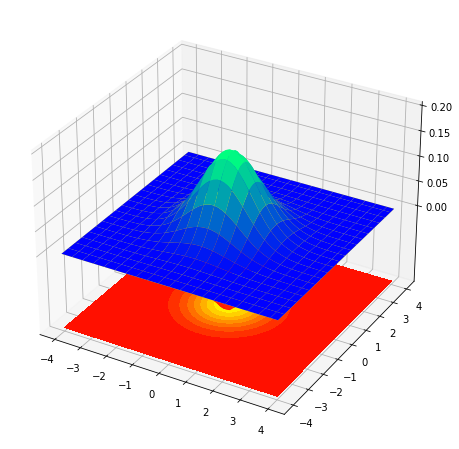

In [27]:

import torch
import numpy as np
import pyro.distributions as dist
from matplotlib import pyplot as plt
from matplotlib import cm



def make_surfaces(n_samples = 60, x_min = -4, x_max = 4, y_min = -4, y_max = 4):

    
    # data
    # Our 2-dimensional distribution will be over variables X and Y
    X = np.linspace(x_min, x_max, n_samples)
    Y = np.linspace(y_min, y_max, n_samples)
    X, Y = np.meshgrid(X, Y)
    
    pos = torch.empty(X.shape + (2,))
    pos[:, :, 0] = torch.from_numpy(X)
    pos[:, :, 1] = torch.from_numpy(Y)
    
    
    # Mean vector and covariance matrix
    #mu =torch.tensor([0., 1.])
    #Sigma =z_posterior.scale.detach()# #torch.tensor([[ 1. , -0.5], [-0.5,  1.5]])
    mu_prior = z_prior.loc.detach()
    sigma_prior=batch_diag(z_prior.scale)
    print(f"\n μ mu_prior {mu_prior} \n 𝜎 sigma_prior {sigma_prior} \n")

    mu_posterior = z_posterior.loc.detach()
    sigma_posterior=batch_diag(z_posterior.scale)
    print(f"\n μ mu_posterior {mu_posterior} \n 𝜎 sigma_posterior {sigma_posterior} \n")
    # Pack X and Y into a single 3-dimensional array


    # The distribution on the variables X, Y packed into pos.
    Z_prior = dist.MultivariateNormal(mu_prior, sigma_prior).log_prob(pos).exp().detach().numpy()
    Z_posterior = dist.MultivariateNormal(mu_posterior, sigma_posterior).log_prob(pos).exp().detach().numpy()
    
    
    return X, Y, Z_prior, Z_posterior

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

X,Y,Z_prior, Z_posterior = make_surfaces()
surf = ax.plot_surface(X, Y, Z_prior, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.winter, zorder = 0)
surf = ax.plot_surface(X, Y, -Z_posterior, rstride=3, cstride=3, linewidth=1, antialiased=True,
               cmap=cm.autumn, zorder = 1)

cset = ax.contourf(X, Y, Z_prior, zdir='z', offset=-0.15, cmap=cm.winter)
cset = ax.contourf(X, Y, Z_posterior, zdifr='z', offset=-0.15, cmap=cm.autumn)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
#ax.view_init(27, -21)



In [49]:
#x,y,mz1, mz2 = make_surfaces()
mx.shape, X.shape

((80, 80), (60, 60))

In [9]:
# generate data
import numpy as np

x = np.arange(-4, 4, 0.5)
y = np.arange(-4, 4, 0.8)
mx, my = np.meshgrid(x, y, indexing='ij')

###########

def batch_diag(batched_variance):
    batch_shape = batched_variance.shape[:-1]
    event_size = batched_variance.size(-1)
    cov = batched_variance.new_zeros(batch_shape + (event_size * event_size,))
    cov[..., ::1 + event_size] = batched_variance
    return cov.reshape(batch_shape + (event_size, event_size))
    
"""
X = np.linspace(-4, 4, 80)
Y = np.linspace(-4, 4, 80)
X, Y = np.meshgrid(X, Y)

pos = torch.empty(X.shape + (2,))
pos[:, :, 0] = torch.from_numpy(X)
pos[:, :, 1] = torch.from_numpy(Y)
    
mu_prior = z_prior.loc.detach()
sigma_prior=batch_diag(z_prior.scale)
print(f"\n μ mu_prior {mu_prior} \n 𝜎 sigma_prior {sigma_prior} \n")

mu_posterior = z_posterior.loc.detach()
sigma_posterior=batch_diag(z_posterior.scale)
print(f"\n μ mu_posterior {mu_posterior} \n 𝜎 sigma_posterior {sigma_posterior} \n")



mz1 =  dist.MultivariateNormal(mu_prior, sigma_prior).log_prob(pos).exp().detach().numpy() #np.abs(mx) + np.abs(my)
mz2 = dist.MultivariateNormal(mu_posterior, sigma_posterior).log_prob(pos).exp().detach().numpy() #mx ** 2 + my ** 2
"""
mz1 =  np.abs(mx) + np.abs(my)
mz2 = mx ** 2 + my ** 2


#x,y, mz1, mz2 =  make_surfaces(n_samples = 80, x_min = -4, x_max = 4, y_min = -4, y_max = 4)

# A fix for "API 'QString' has already been set to version 1"
# see https://github.com/enthought/pyface/issues/286#issuecomment-335436808
from sys import version_info
if version_info[0] < 3:
    import pyface.qt

#def v2_mayavi(transparency=True):
from mayavi import mlab
fig = mlab.figure()

#ax_ranges = [-1, 1, -1, 1, 0, 0.05]
#ax_scale = [1.0, 1.0, 1.0]
#ax_extent = ax_ranges * np.repeat(ax_scale, 2)

#X, Y, Z_prior, Z_posterior = make_surfaces()

#surf1 = mlab.surf(X, Y, Z_prior, colormap='Blues')
#surf2 = mlab.surf(X, Y, Z_posterior, colormap='Oranges')

surf1 = mlab.surf(mx, my, mz1, colormap='Blues')
surf2 = mlab.surf(mx, my, mz2, colormap='Oranges')


#surf1.actor.actor.scale = ax_scale
#surf2.actor.actor.scale = ax_scale 


#if transparency:
#surf1.actor.property.opacity = 0.5
#surf2.actor.property.opacity = 0.5
#fig.scene.renderer.use_depth_peeling = 1

mlab.view(60, 74, 17, [-2.5, -4.6, -0.3])
mlab.outline(surf1, color=(.7, .7, .7))#, extent=ax_extent)
mlab.axes(surf1, color=(.7, .7, .7) , extent=ax_extent,
            ranges=ax_ranges,
             xlabel='x', ylabel='y', zlabel='z')


qt.qpa.window: <QNSWindow: 0x7ff537ee3340; contentView=<QNSView: 0x7ff5408398c0; QCocoaWindow(0x60000096e100, window=QWidgetWindow(0x600001b00960, name="QMainWindowClassWindow"))>> has active key-value observers (KVO)! These will stop working now that the window is recreated, and will result in exceptions when the observers are removed. Break in QCocoaWindow::recreateWindowIfNeeded to debug.


NameError: name 'ax_extent' is not defined

In [ ]:
s = mlab.test_plot3d()
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

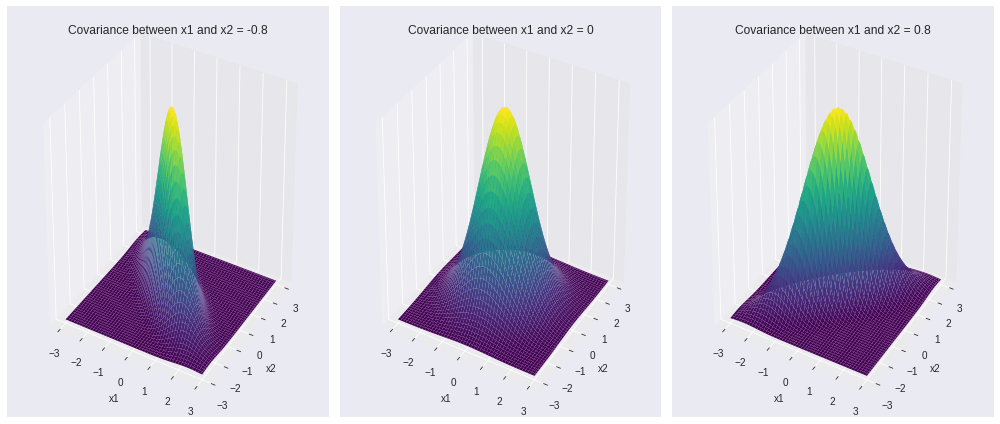

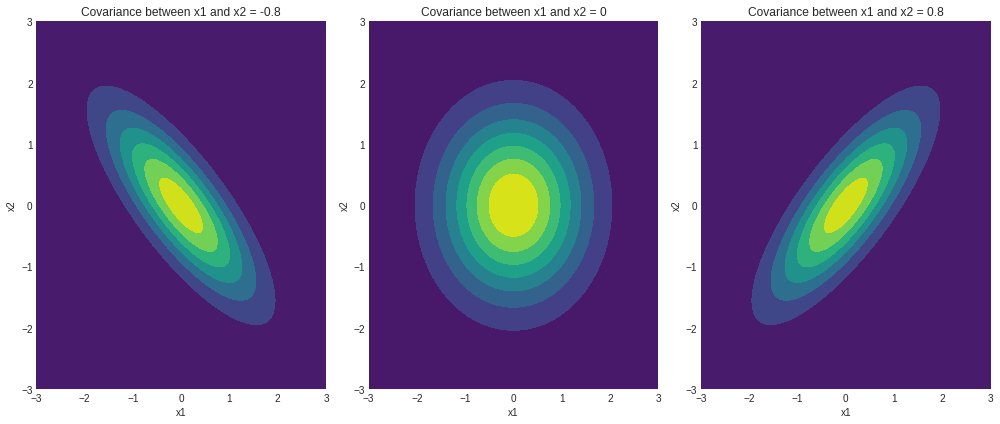

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import multivariate_normal




plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()
 
# Initializing the random seed
random_seed=1000
 
# List containing the variance
# covariance values
cov_val = [0, 0, ]
 
# Setting mean of the distributino
# to be at (0,0)
mean = np.array([0,0])
 
# Storing density function values for
# further analysis
pdf_list = []



 
# Iterating over different covariance values
for idx, val in enumerate(cov_val):
     
    # Initializing the covariance matrix
    cov = np.array([[1, val], [val, 1]])
     
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean,
                                seed = random_seed)
     
    # Generating a meshgrid complacent with
    # the 3-sigma boundary
    mean_1, mean_2 = mean[0], mean[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
     
    x = np.linspace(-3*sigma_1, 3*sigma_1, num=100)
    y = np.linspace(-3*sigma_2, 3*sigma_2, num=100)
    X, Y = np.meshgrid(x,y)
     
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
    
    # Plotting the density function values
    key = 131+idx
    ax = fig.add_subplot(key, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {val}')
    pdf_list.append(pdf)
    ax.axes.zaxis.set_ticks([])
 
plt.tight_layout()
plt.show()
 
# Plotting contour plots
for idx, val in enumerate(pdf_list):
    plt.subplot(1,3,idx+1)
    plt.contourf(X, Y, val, cmap='viridis')
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f'Covariance between x1 and x2 = {cov_val[idx]}')
plt.tight_layout()
plt.show()

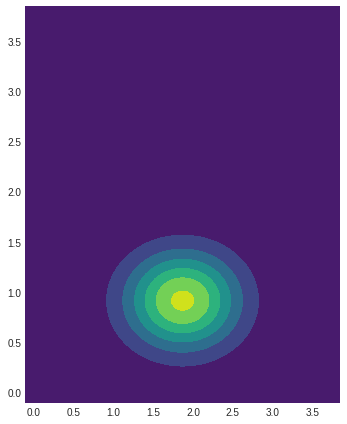

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import multivariate_normal

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()

#b0,g
#[[1.8684394 0.911229 ]];[[0.2479071  0.11640924]]

gamma_only = np.array([[1.8684394, 0.911229 ],[0.2479071,  0.11640924]])
#bg
#[[ 0.34528574 -0.8122046 ]];[[0.533661   0.68397766]]
beta_gamma = np.array([[ 0.34528574, -0.8122046 ],[0.533661,   0.68397766]])
#bg0
#[[ 6.5334396 -2.8171217]];[[2.562125 1.368544]]
beta_only = np.array([[ 6.5334396, -2.8171217],[2.562125 ,1.368544]])

reg_list = [beta_only, gamma_only, beta_gamma]

# Initializing the random seed
random_seed=1000

mean = [1.8684394, 0.911229 ]

# Initializing the covariance matrix
cov = np.array([[0.2479071,0], [0, 0.11640924]])
    
# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov, mean = mean,
                            seed = random_seed)

# Generating a meshgrid complacent with
# the 3-sigma boundary

mean_1, mean_2 = mean[0], mean[1]
sigma_1, sigma_2 = 0.2479071, 0.11640924 
mean_ = np.max(mean)
cov_ = np.max(cov)
x = np.linspace(mean_-8*cov_,mean_ + 8*cov_, num=100)
y = np.linspace(mean_-8*cov_,mean_ + 8*cov_, num=100)

X, Y = np.meshgrid(x,y)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# Plotting the density function values
#key = 131


plt.tight_layout()
plt.show()
 
# Plotting contour plots

plt.subplot(1,3,1)
plt.contourf(X, Y, pdf, cmap='viridis')

plt.tight_layout()
plt.show()

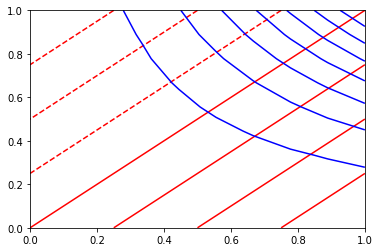

In [2]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(0, 1, 10)
Y = np.linspace(0, 1, 10)

x,y = np.meshgrid(X,Y)

f1 = np.cos(x*y)
f2 = x-y

plt.contour(x,y,f2,colors='red')
plt.contour(x,y,f1,colors='blue')
plt.show()

[[ 2.562125  0.      ]
 [ 0.        1.368544]]
[[ 0.2479071   0.        ]
 [ 0.          0.11640924]]
[[ 0.533661    0.        ]
 [ 0.          0.68397766]]


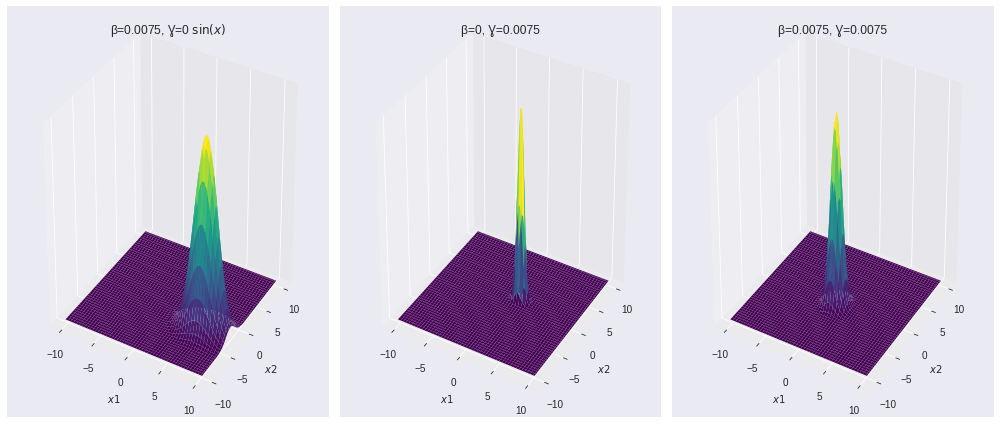

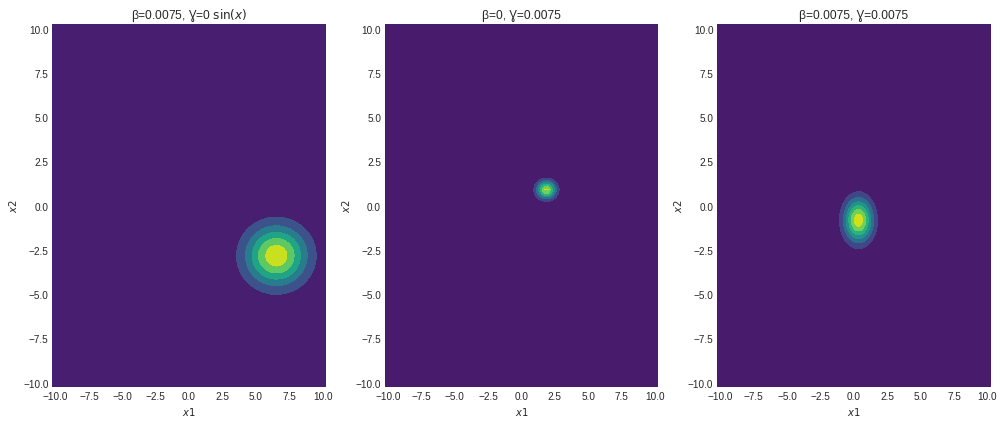

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import multivariate_normal


gamma_only = np.array([[1.8684394, 0.911229 ],[0.2479071,  0.11640924]])
#bg
#[[ 0.34528574 -0.8122046 ]];[[0.533661   0.68397766]]
beta_gamma = np.array([[ 0.34528574, -0.8122046 ],[0.533661,   0.68397766]])
#bg0
#[[ 6.5334396 -2.8171217]];[[2.562125 1.368544]]
beta_only = np.array([[ 6.5334396, -2.8171217],[2.562125 ,1.368544]])

reg_list = [beta_only, gamma_only, beta_gamma]


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize']=14,6
fig = plt.figure()
 
# Initializing the random seed
random_seed=1000
 
# List containing the variance
# covariance values
cov_val = [0, 0, 0]
 
# Setting mean of the distributino
# to be at (0,0)
#mean = np.array([0,0])
 
# Storing density function values for
# further analysis
pdf_list = []

# Iterating over different covariance values

m1_max = 0
m2_max = 0
s1_max = 0
s2_max = 0

for val in reg_list:
    cov = np.array([[val[-1][0],0], [0,val[-1][1]]])
    mean = val[0]

    mean_1, mean_2 = mean[0], mean[1]
    m1_max = max(np.abs(m1_max),np.abs(mean_1))
    m2_max = max(np.abs(m2_max),np.abs(mean_2))

    sigma_1, sigma_2 = cov[0,0], cov[1,1]
    s1_max = max(s1_max,sigma_1)
    s2_max = max(s2_max,sigma_2)


title = ["β=0.0075, Ɣ=0 $\s (x)$", "β=0, Ɣ=0.0075", "β=0.0075, Ɣ=0.0075"]
for idx, val in enumerate(reg_list):
    # Initializing the covariance matrix
    cov = np.array([[val[-1][0],0], [0,val[-1][1]]])
    print(cov)
    mean = val[0]
    #print(mean)

    
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean,
                                seed = random_seed)
     
    # Generating a meshgrid complacent with
    # the 3-sigma boundary
    mean_1, mean_2 = mean[0], mean[1]
    sigma_1, sigma_2 = cov[0,0], cov[1,1]
    
    s_max = max(np.abs(s1_max), np.abs(s2_max))

    x = np.linspace(-4*s_max, 4*s_max, num=100)
    y = np.linspace(-4*s_max, 4*s_max, num=100)
    X, Y = np.meshgrid(x,y)
     
    # Generating the density function
    # for each point in the meshgrid
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])
    
    # Plotting the density function values
    key = 131+idx
    ax = fig.add_subplot(key, projection = '3d')
    ax.plot_surface(X, Y, pdf, cmap = 'viridis')
    plt.xlabel("$x1$")
    plt.ylabel("$x2$")
    plt.title(title[idx])
    pdf_list.append(pdf)
    ax.axes.zaxis.set_ticks([])

plt.tight_layout()
plt.show()

# Plotting contour plots
for idx, val in enumerate(pdf_list):
    plt.subplot(1,3,idx+1)
    plt.contourf(X, Y, val, cmap='viridis')
    plt.xlabel("$x1$")
    plt.ylabel("$x2$")
    plt.title(f'{title[idx]}')
plt.tight_layout()
plt.show()